# IdentiBreed - The dog breed identification AI

In this notebook I will go through an entire workflow of my first Neural Network/Deep Learning model. The ultimate goal of this project is creating an answer (a late submission but whatever) to the "Dog Breed Identification" competition available on Kaggle under <a href="https://www.kaggle.com/competitions/dog-breed-identification">this link</a>

To achieve this goal I will build a multi-class classification model with TensorFlow and TensorFlow Hub. 

If you've seen any of my previous projects (at the time of writing - 09.03.2023 the ONLY project) on my <a href="https://github.com/Ale-Cie">GitHub</a> you can expect the typical from me - I will follow loosely few steps, that is:
 - Defining the problem
 - Exploring the data
 - Create initial model(s) and tune the hyperparameters
 - Evaluate the model(s) 
 - Experiment untill satisfied 


## Getting the workspace ready

Let's start by importing the necessary tools into our notebook and making sure we're using the GPU for our notebook

In [1]:
# I will start with TensorFlow and TensorFlow Hub
# To make sure we are using GPU accelerator we click on Runtime > Change runtime type and select GPU
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

from IPython.display import Image
from sklearn.model_selection import train_test_split

%load_ext tensorboard



### Getting the dataset ready

Now we have to change the images provided by Kaggle into tensors, that is numerical values.

However that will come shortly, let's first inspect the "labels"

In [2]:
try:
    labels_csv = pd.read_csv("./data/labels.csv")
except:
    labels_csv = pd.read_csv("/content/drive/MyDrive/IdentiBreed/labels.csv")
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

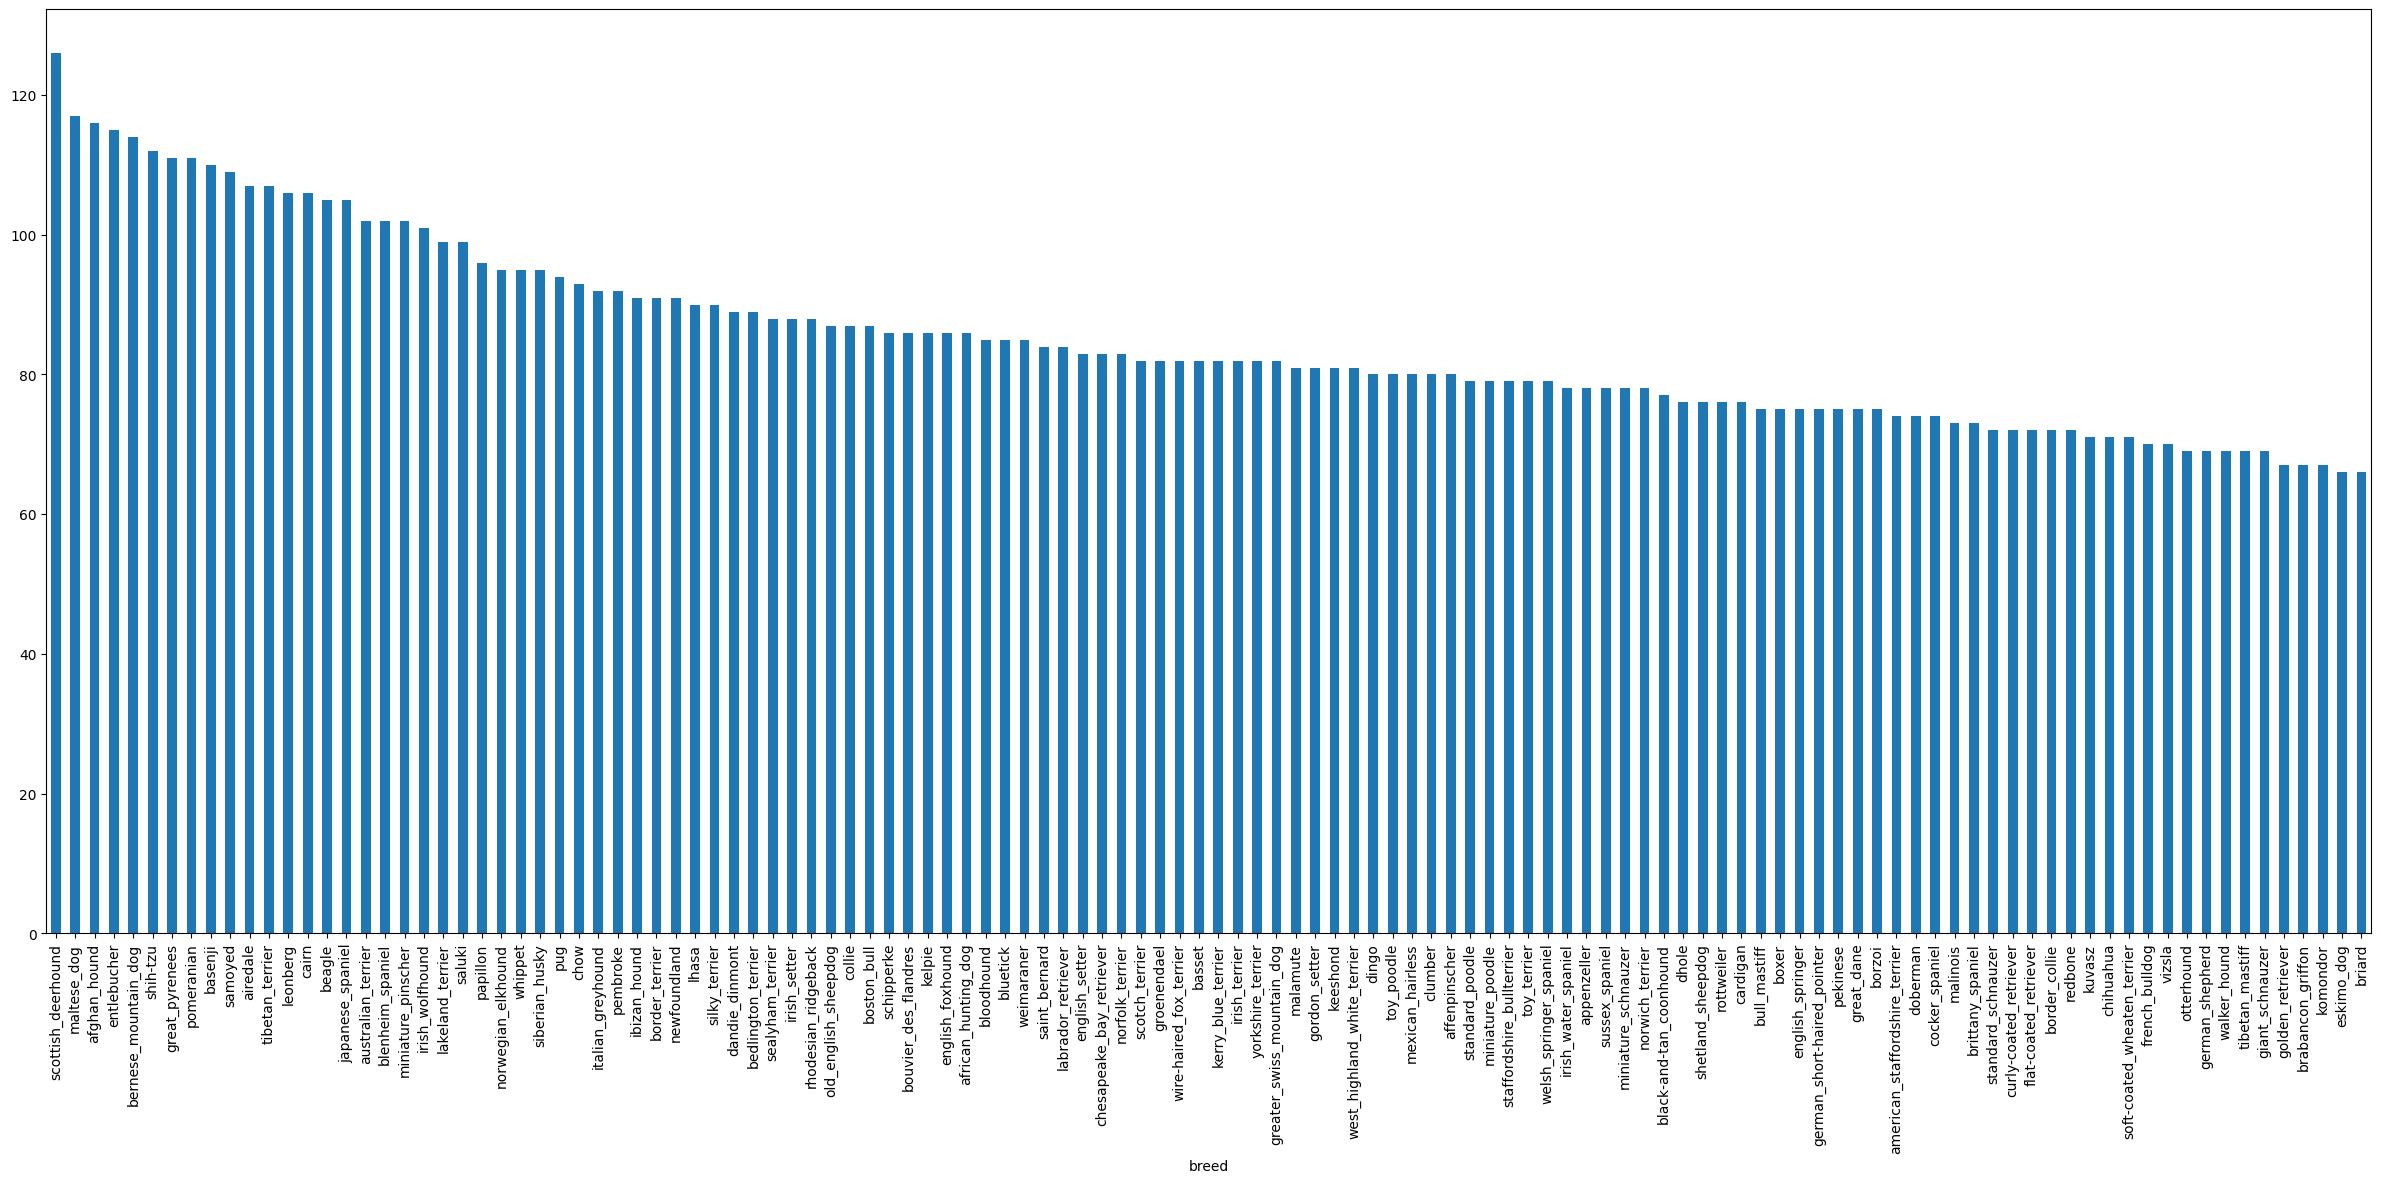

In [3]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30, 12));

In [4]:
try:
    trainpaths = [f"./data/train/{id}.jpg" for id in labels_csv["id"]]
except:
    trainpaths = [f"/content/drive/MyDrive/IdentiBreed/train/{id}.jpg" for id in labels_csv["id"]]

len(trainpaths)

10222

In [5]:
unique_labels = np.unique(np.array(labels_csv["breed"]))
bool_labels = [label == unique_labels for label in labels_csv["breed"]]
print(bool_labels[0].astype(int))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Preparing the data for modelling

Kaggle in this competition provides us with train and test folders, but we have to remember that the test folder does not contain the labels - we have to predict those and submit them, which then scores us on Kaggle. 

We have to split the train images into a train set and validation set with `train_test_split()` (so a test set but the one we can score ourselves). At the very beginning we have to remember that the train data is 10222 images long, so starting small might be a better idea...

Let's create a parameter that we can change as we need

In [9]:
IMG_NUM = 1000 #@param {type:"slider", min:1000, max:10222}

In [10]:
# Renaming the images and labels as X and y
X = trainpaths
y = bool_labels

# Splitting the data into train and validation that is as big as the IMG_NUM
X_train, X_validation, y_train, y_validation = train_test_split(X[:IMG_NUM], 
                                                                y[:IMG_NUM], 
                                                                test_size=0.2,
                                                                random_state=31)

len(X_train), len(y_train), len(X_validation), len(y_validation)


(800, 800, 200, 200)

### Turning images into Tensors

To make our lives easier I will define functions as we go. Let's start by a function that takes the images from our paths and turns them into Tensors.

In [6]:
IMG_SIZE = 224

def turn_to_tensor(img_path):
  """
  This function turns an image under path provided into a Tensor. 
  Returns a Tensor
  """

  # Load in the image file and turn it into a numerical Tensor
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)

  # Normalizing the image and resizing it to a constant (244x244)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, size=(IMG_SIZE, IMG_SIZE))

  return img

def make_tuple(img, label):
  """
  Takes an image Tensor and returns a pair of image, label Tensors
  """

  image = turn_to_tensor(img)
  return image, label


Now that we have this function it will be a simple matter of putting all filepaths through it and saving the results.

### Creating batches of data

In [11]:
BATCH_SIZE = 32

def split_to_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates data batches out of image and label pairs (X and y pairs).
  Shuffles the data if it's training data.
  Doesn't shuffle if it's validation data.
  Accepts the Kaggle test data.
  """

  if test_data:
    #print("Splitting test data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(turn_to_tensor).batch(batch_size)
    return data_batch
  elif valid_data:
    print("Splitting validation data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(make_tuple).batch(batch_size)
    return data_batch
  else:
    # This one we want to shuffle
    print("Splitting training data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(make_tuple).batch(batch_size)
    return data_batch


In [27]:
# Let's create train and validation batches now

train_data = split_to_batches(X_train, y_train)
validation_data = split_to_batches(X_validation, y_validation, valid_data=True)

Splitting training data into batches
Splitting validation data into batches


## Building a model

In [28]:
# Input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Output shape
OUTPUT_SHAPE = len(unique_labels)

# TensorFlow model URL
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [29]:
# Creating a function

def create_model(input_shape= INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url= MODEL_URL):
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # Layer 1 - Input layer
      tf.keras.layers.Dense(
          units= output_shape, 
          activation= "softmax") # Layer 2 - Output layer 

  ])

  model.compile(
      loss= tf.keras.losses.CategoricalCrossentropy(),
      optimizer= tf.keras.optimizers.Adam(),
      metrics= ["accuracy"]
  )

  model.build(input_shape)

  return model

In [30]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks

In [31]:
def tensorboard_callback():
  try:
    logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  except:
    logdir = os.path.join("/content/drive/MyDrive/IdentiBreed/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience= 3)

## Training the model

To make sure that everything is working I will start with a limited amount of images, as set by the `IMG_NUM` variable

In [32]:
NUM_EPOCHS = 100 #@param {type: "slider", min: 10, max: 150, step: 10 }

In [33]:
def train_model():
  model = create_model()
  tensorboard = tensorboard_callback()

  model.fit(x= train_data,
            epochs= NUM_EPOCHS,
            validation_data= validation_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [34]:
model = train_model()

Epoch 1/100
25/25 [==============================] - 8s 253ms/step - loss: 4.5768 - accuracy: 0.0950 - val_loss: 3.2608 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 6s 223ms/step - loss: 1.6547 - accuracy: 0.6675 - val_loss: 2.0552 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 6s 222ms/step - loss: 0.5729 - accuracy: 0.9337 - val_loss: 1.5741 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 6s 223ms/step - loss: 0.2495 - accuracy: 0.9937 - val_loss: 1.4172 - val_accuracy: 0.5850
Epoch 5/100
25/25 [==============================] - 6s 222ms/step - loss: 0.1428 - accuracy: 0.9975 - val_loss: 1.3463 - val_accuracy: 0.6050
Epoch 6/100
25/25 [==============================] - 5s 220ms/step - loss: 0.0980 - accuracy: 0.9987 - val_loss: 1.3089 - val_accuracy: 0.5950
Epoch 7/100
25/25 [==============================] - 5s 219ms/step - loss: 0.0745 - accuracy: 1.0000 - val_loss: 1.2708 - val_accuracy: 0.6200

## Reading the TensorBoard Logs

In [83]:
%tensorboard --logdir /Users/aleksanderciesielski/Conda/IdentiBreed/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
E0410 22:33:48.895022 8823112000 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/DL-env/lib/python3.10/site-packages/tensorboard/backend/application.py", line 123, in TensorBoardWSGIApp
    plugin = loader.load(context)
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/DL-env/lib/python3.10/site-packages/tensorboard_plugin_wit/wit_plugin_loader.py", line 57, in load
    from tensorboard_plugin_wit.wit_plugin import WhatIfToolPlugin
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/DL-env/lib/python3.10/site-packages/tensorboard_plugin_wit/wit_plugin.py", line 40, in <module>
    from tensorboard_plugin_wit._utils import common_utils
  File "/Users/aleksanderciesielski/opt/miniconda3/envs/DL-env/lib/python3.10/site-packages/tensorboard_plugin_wit/_utils/common_utils.py", line 17

## Making predictions on the validation set

In [36]:
pred_probabilities = model.predict(validation_data, verbose=1)
pred_probabilities

7/7 [==============================] - 2s 180ms/step


array([[2.3672595e-03, 1.5538780e-04, 1.0085568e-04, ..., 9.2542061e-05,
        5.1597886e-05, 4.1108280e-02],
       [7.9977708e-03, 9.9347974e-04, 4.9424125e-04, ..., 2.3332119e-04,
        1.0526440e-03, 1.3397827e-02],
       [1.0465208e-03, 1.0368129e-04, 9.2755875e-04, ..., 1.1654673e-01,
        4.5601800e-03, 4.4458555e-03],
       ...,
       [3.7139500e-03, 3.5456046e-03, 9.5026371e-05, ..., 1.4003432e-04,
        3.4884177e-03, 5.3549506e-04],
       [2.4713960e-04, 6.5667229e-04, 7.4191280e-06, ..., 1.6974976e-05,
        1.9547599e-05, 3.6535349e-03],
       [5.4848229e-04, 1.0106459e-03, 1.3887102e-03, ..., 5.9185843e-03,
        6.4207609e-03, 1.1385686e-03]], dtype=float32)

In [8]:
def label_prediction(probabilities):
  return unique_labels[np.argmax(probabilities)]

def unbatch_data(batched_data):
  images = []
  labels = []

  for image, label in batched_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images, labels

In [38]:
val_images, val_labels = unbatch_data(validation_data)

In [39]:
def plot_pred(prediction_probabilities, labels, images, n=0):

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  pred_label = label_prediction(pred_prob)

  if pred_label == true_label:
    t_color = "tab:green"
  else:
    t_color = "tab:red"

  plt.imshow(image)
  plt.title("{} {:0.3f}% {}".format(
      pred_label,
      np.max(pred_prob)*100,
      true_label),
      color= t_color)
  plt.xticks([])
  plt.yticks([])


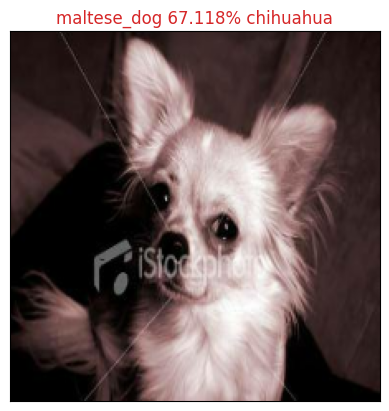

In [40]:
plot_pred(
    prediction_probabilities=pred_probabilities,
    labels= val_labels,
    images= val_images
)

In [41]:
def plot_pred_conf(prediction_probabilities, labels, n=0):
  pred_probabilities, true_label = prediction_probabilities[n], labels[n]

  pred_label = label_prediction(pred_probabilities)

  top_10_idx = pred_probabilities.argsort()[-10:][::-1]
  top_10_confidences = pred_probabilities[top_10_idx]
  top_10_labels = unique_labels[top_10_idx]

  top_plot = plt.bar(np.arange(len(top_10_labels)),
                     top_10_confidences,
                     color="grey")
  plt.xticks(np.arange(len(top_10_labels)),
             labels=top_10_labels,
             rotation="vertical")
  
  if np.isin(true_label, top_10_labels):
    top_plot[np.argmax(top_10_labels == true_label)].set_color("green")
  else:
    pass

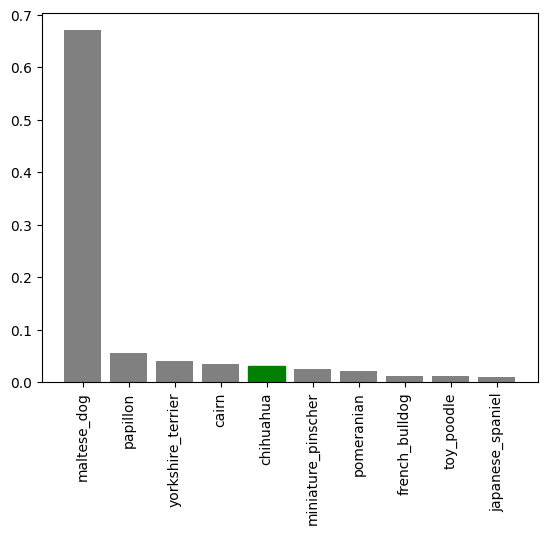

In [42]:
plot_pred_conf(
    prediction_probabilities=pred_probabilities,
    labels= val_labels
    )

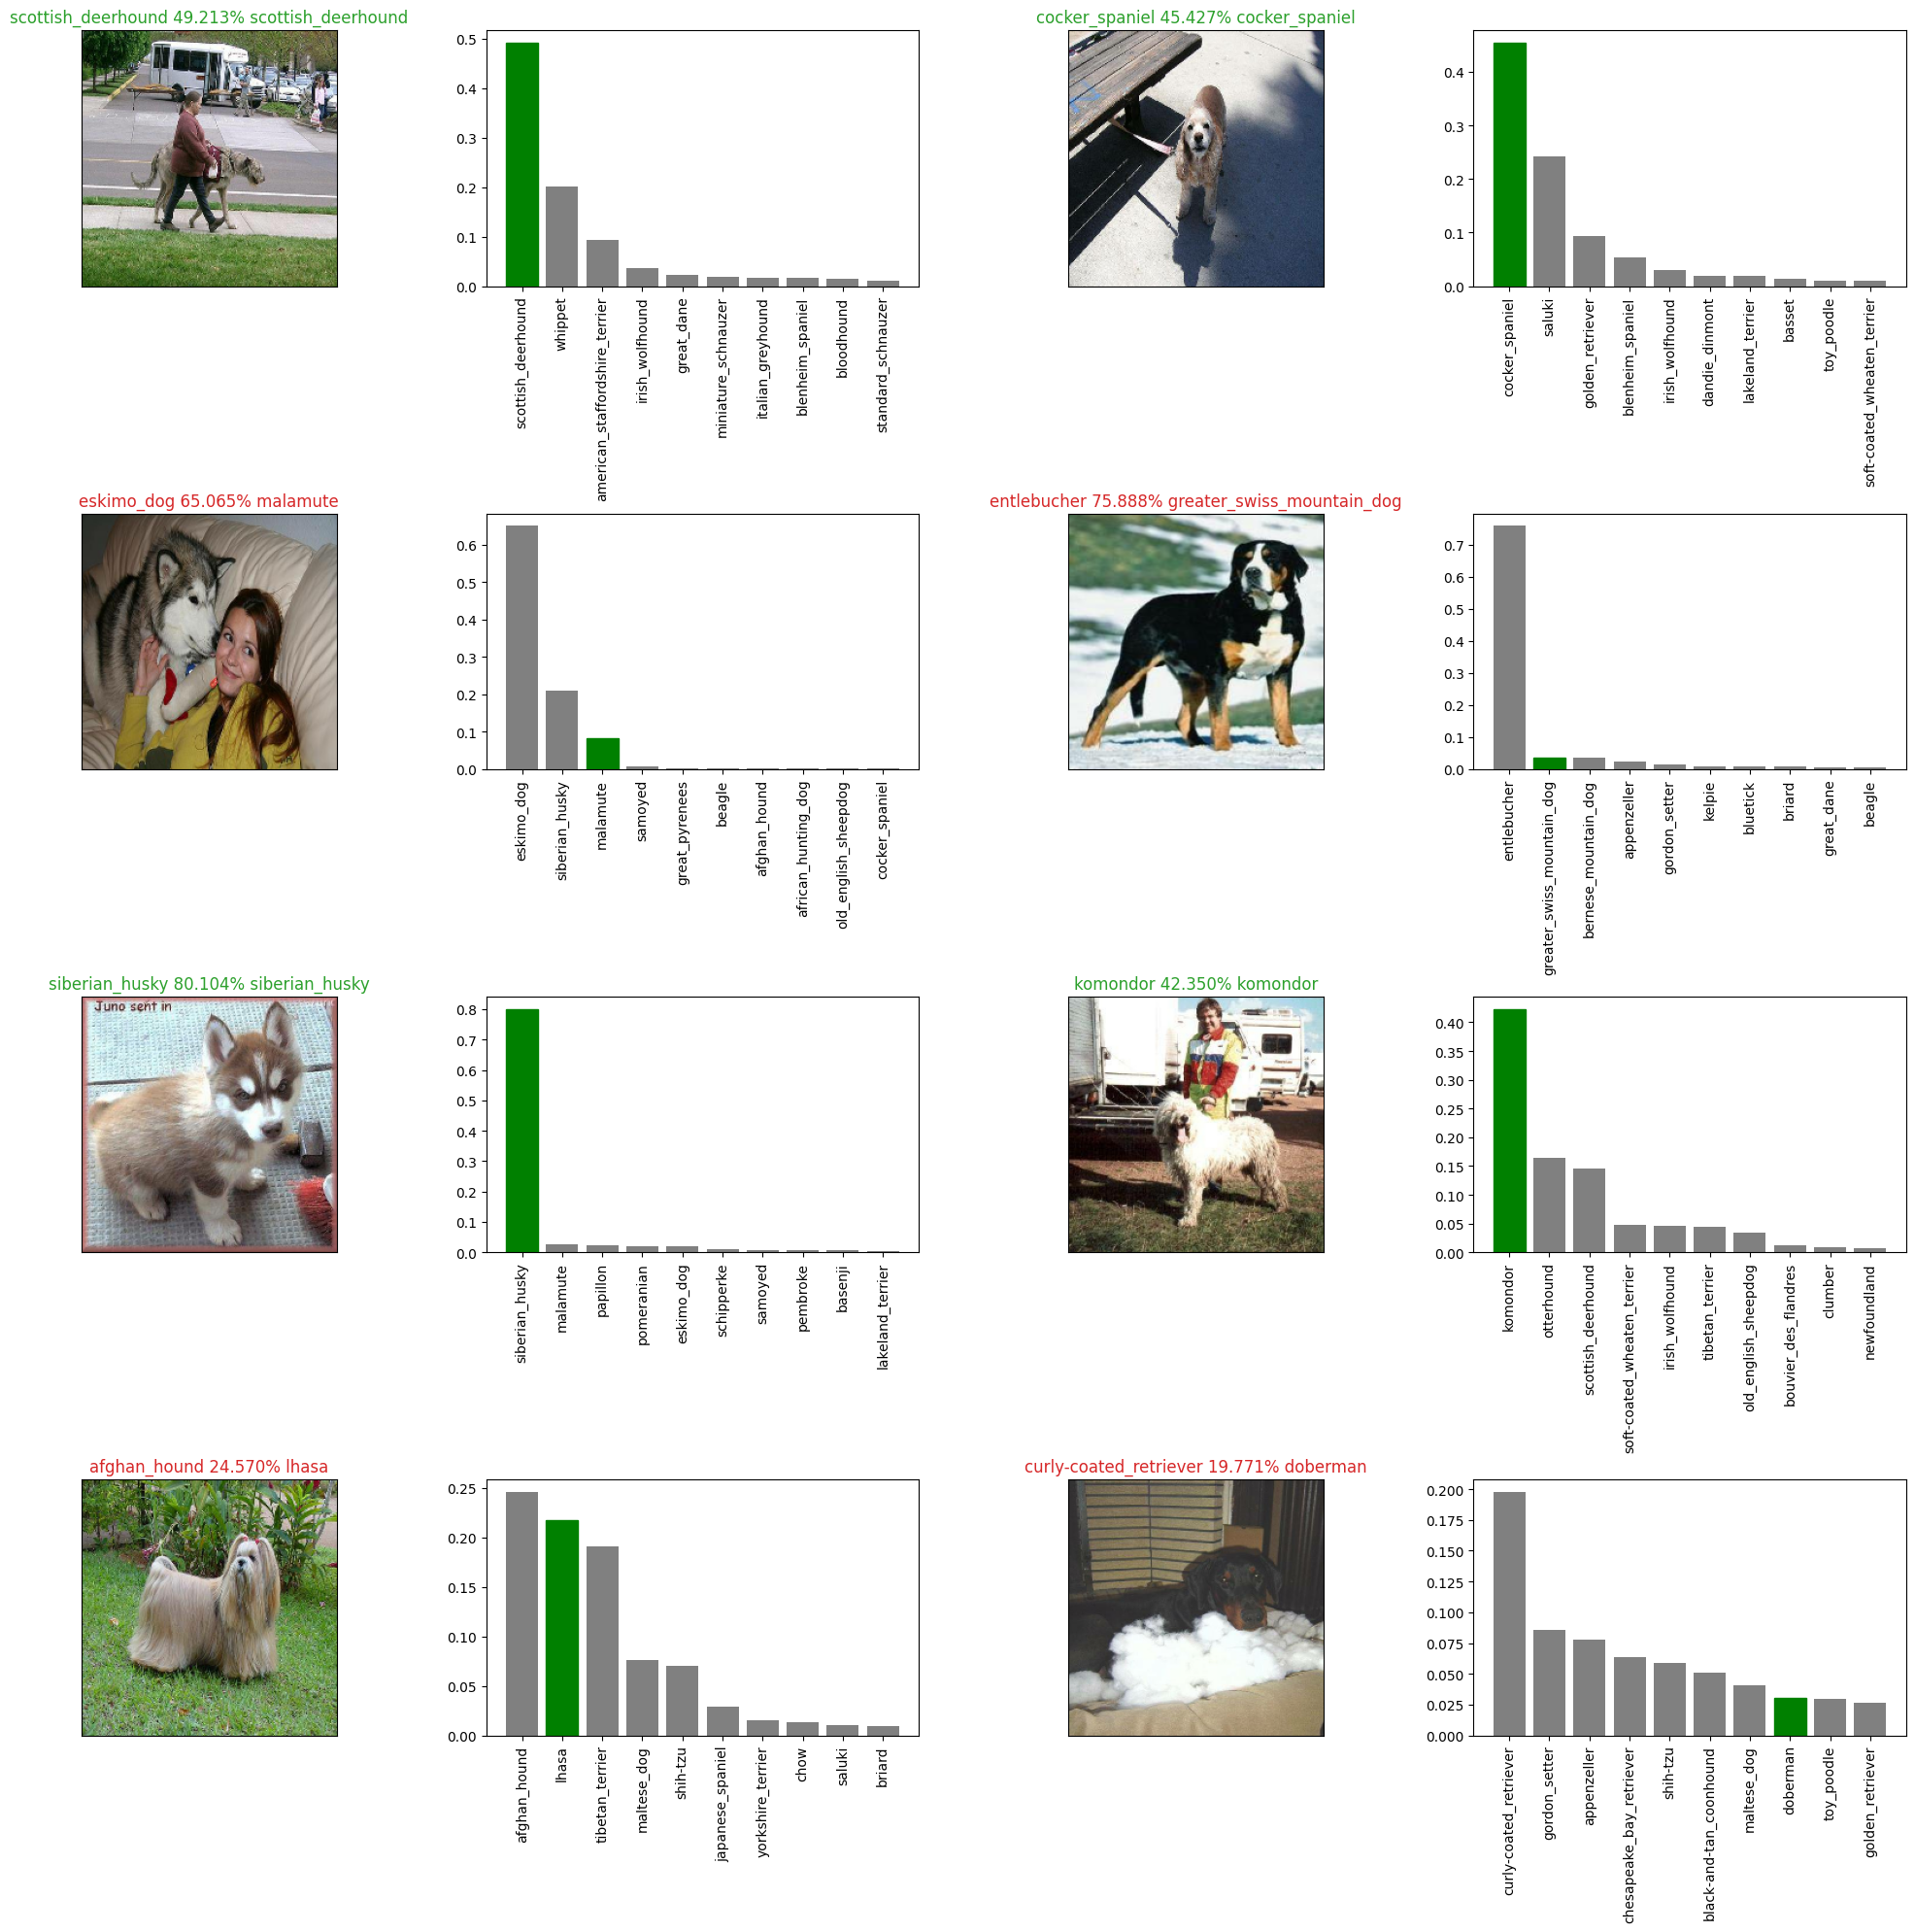

In [43]:
i_multiplier = 4
n_rows = 4
n_cols = 2
n_images = n_rows * n_cols

plt.figure(figsize=(10*n_cols, 5*n_rows))
for i in range(n_images):
  plt.subplot(n_rows, 2*n_cols, 2*i+1)
  plot_pred(
      prediction_probabilities= pred_probabilities,
      labels = val_labels,
      images = val_images,
      n = i+i_multiplier
  )
  plt.subplot(n_rows, 2*n_cols, 2*i+2)
  plot_pred_conf(
      prediction_probabilities= pred_probabilities,
      labels = val_labels,
      n= i+i_multiplier
  )
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving the model

In [9]:
def save_model(model, suffix=None):
  try:
    modeldir = os.path.join("./models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  except:  
    modeldir = os.path.join("/content/drive/MyDrive/IdentiBreed/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s")) 
  model_path = modeldir + "-" + suffix + ".h5"

  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def load_model(model_path):
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  
  return model

In [45]:
save_model(model, "1000-imgs-MobileNetV2-Adam")

Saving model to: ./models/20230410-21401681155648-1000-imgs-MobileNetV2-Adam.h5...


'./models/20230410-21401681155648-1000-imgs-MobileNetV2-Adam.h5'

## Training model on the full data set

In [46]:
full_data = split_to_batches(
    X= X,
    y= y,
)

Splitting training data into batches


In [47]:
full_model = create_model()

In [48]:
full_model_tensorboard = tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [49]:
full_model.fit(
    x= full_data,
    epochs= NUM_EPOCHS,
    callbacks = [full_model_tensorboard, full_model_early_stopping]
)

Epoch 1/100
320/320 [==============================] - 57s 175ms/step - loss: 1.3401 - accuracy: 0.6687
Epoch 2/100
320/320 [==============================] - 56s 174ms/step - loss: 0.4001 - accuracy: 0.8790
Epoch 3/100
320/320 [==============================] - 57s 177ms/step - loss: 0.2345 - accuracy: 0.9383
Epoch 4/100
320/320 [==============================] - 57s 178ms/step - loss: 0.1527 - accuracy: 0.9643
Epoch 5/100
320/320 [==============================] - 58s 180ms/step - loss: 0.1067 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 127s 398ms/step - loss: 0.0764 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 55s 173ms/step - loss: 0.0582 - accuracy: 0.9921
Epoch 8/100
320/320 [==============================] - 57s 177ms/step - loss: 0.0455 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 61s 191ms/step - loss: 0.0372 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 59s 184

In [50]:
save_model(full_model, "full-image-set-MobileNetV2-Adam")

Saving model to: ./models/20230410-22001681156811-full-image-set-MobileNetV2-Adam.h5...


'./models/20230410-22001681156811-full-image-set-MobileNetV2-Adam.h5'

## Making predictions on test data

In [56]:
try:
    test_files = os.listdir("./data/test")
    X_test = [f"./data/test/{file}" for file in test_files]
except:
    test_files = os.listdir("/content/drive/MyDrive/IdentiBreed/test")
    X_test = [f"/content/drive/MyDrive/IdentiBreed/test/{file}" for file in test_files]
len(X_test)


10357

In [57]:
test_data = split_to_batches(
    X= X_test,
    test_data= True
)

Splitting test data into batches


In [113]:
try:
  test_predictions = full_model.predict(test_data, verbose=1)
except:
  full_model = load_model("./models/20230409-19141681060478-full-image-set-MobileNetV2-Adam.h5")
  test_predictions = full_model.predict(test_data, verbose=1)

324/324 [==============================] - 59s 182ms/step


In [59]:
np.savetxt("./predictions_array.csv", test_predictions, delimiter=",")

### Preparing the predictions for Kaggle publication

In [115]:
index_names = [name[:-4] for name in os.listdir("./data/test/")]
try:
    test_predictions = pd.DataFrame(test_predictions, columns=unique_labels, index=index_names)
except:
    test_predictions = pd.read_csv("./predictions_array.csv", names=unique_labels)
    test_predictions.index = index_names

test_predictions.index.name = "id"
test_predictions

affenpinscher  afghan_hound   
id                                                              
266490a2b053a4a3bf68e779f28fb5a9   6.067172e-11  5.289345e-07  \
dae9fd18836d8df20989ef0101771d4b   3.992902e-03  1.906648e-04   
079a40f22b0fad9a66f76797b62bb930   1.001681e-07  8.510954e-11   
ab8462f9a501d362041d47582fddc9ad   5.067123e-10  9.104802e-09   
8895089b432e020cc42e6262b5a1c2dd   1.727797e-10  6.365432e-10   
...                                         ...           ...   
e6d6ff5b33e6174158d5ab05a7eda95c   1.512126e-10  1.382240e-08   
474a1be9d5932a9e75b28384961ad17f   1.510392e-08  3.696979e-09   
1b7421b4d34056c04a9b2d109e503fe4   2.491218e-07  3.180805e-06   
51a79ea47f89ff2ebaa879d5ccf132f0   3.986116e-11  2.299899e-09   
8f4210be609c47ccd3c611a106e6c095   1.341721e-07  4.799750e-08   

                                  african_hunting_dog      airedale   
id                                                                    
266490a2b053a4a3bf68e779f28fb5a9         2.288842e-09  1.767885e-07  \
dae9fd18836d8df20989ef0101771d4b         4.515697e-06  6.143756e-08   
079a40f22b0fad9a66f76797b62bb930         4.046193e-12  2.626193e-10   
ab8462f9a501d362041d47582fddc9ad         4.393055e-12  1.854505e-08   
8895089b432e020cc42e6262b5a1c2dd         1.453551e-08  1.976562e-11   
...                                               ...           ...   
e6d6ff5b33e6174158d5ab05a7eda95c         2.311892e-14  2.789755e-12   
474a1be9d5932a9e75b28384961ad17f         6.444832e-06  4.617261e-09   
1b7421b4d34056c04a9b2d109e503fe4         9.534643e-06  5.326935e-08   
51a79ea47f89ff2ebaa879d5ccf132f0         1.889061e-10  6.806785e-09   
8f4210be609c47ccd3c611a106e6c095         7.160650e-07  2.071721e-05   

                                  american_staffordshire_terrier   
id                                                                 
266490a2b053a4a3bf68e779f28fb5a9                    1.544486e-12  \
dae9fd18836d8df20989ef0101771d4b                    1.870755e-08   
079a40f22b0fad9a66f76797b62bb930                    4.258122e-11   
ab8462f9a501d362041d47582fddc9ad                    1.515666e-11   
8895089b432e020cc42e6262b5a1c2dd                    7.888821e-10   
...                                                          ...   
e6d6ff5b33e6174158d5ab05a7eda95c                    5.414185e-11   
474a1be9d5932a9e75b28384961ad17f                    4.164243e-11   
1b7421b4d34056c04a9b2d109e503fe4                    1.271016e-03   
51a79ea47f89ff2ebaa879d5ccf132f0                    1.347931e-10   
8f4210be609c47ccd3c611a106e6c095                    8.548649e-10   

                                   appenzeller  australian_terrier   
id                                                                   
266490a2b053a4a3bf68e779f28fb5a9  6.733816e-07        2.763490e-13  \
dae9fd18836d8df20989ef0101771d4b  2.808364e-08        7.263982e-04   
079a40f22b0fad9a66f76797b62bb930  3.067131e-11        4.261868e-12   
ab8462f9a501d362041d47582fddc9ad  4.232869e-08        4.186602e-09   
8895089b432e020cc42e6262b5a1c2dd  1.114175e-09        7.873066e-08   
...                                        ...                 ...   
e6d6ff5b33e6174158d5ab05a7eda95c  1.087355e-13        2.264201e-10   
474a1be9d5932a9e75b28384961ad17f  1.745006e-07        1.643175e-08   
1b7421b4d34056c04a9b2d109e503fe4  4.872270e-06        2.541250e-05   
51a79ea47f89ff2ebaa879d5ccf132f0  2.254321e-08        1.695142e-11   
8f4210be609c47ccd3c611a106e6c095  3.588713e-09        2.087795e-08   

                                       basenji        basset        beagle   
id                                                                           
266490a2b053a4a3bf68e779f28fb5a9  8.697263e-12  7.894853e-05  9.107525e-10  \
dae9fd18836d8df20989ef0101771d4b  5.338183e-09  1.580358e-08  1.451679e-10   
079a40f22b0fad9a66f76797b62bb930  2.363878e-12  6.141606e-12  1.431978e-11   
ab8462f9a501d362041d47582fddc9ad  1.347967e-11  8.208683e-10  1.403971e-11   


In [116]:
test_predictions.to_csv("./full_model_preds_v1.csv")

## Making predictions on our own pictures

In [10]:
identibreed = load_model("/Users/aleksanderciesielski/Conda/IdentiBreed/models/20230410-22001681156811-full-image-set-MobileNetV2-Adam.h5")

Loading saved model from: /Users/aleksanderciesielski/Conda/IdentiBreed/models/20230410-22001681156811-full-image-set-MobileNetV2-Adam.h5...
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [86]:
def prediction_on_the_go(file_paths):
  predicted_files = {}
  print("Predicting dog breeds from images in './images' folder.")
  print("This could take a moment...")
  i = 0
  for file in os.listdir(file_paths):
    if file == ".ipynb_checkpoints" or file == ".DS_Store" or file == "images.txt":
      pass
    else:
      img_path = file_paths + "/" + file
      img = split_to_batches([img_path], test_data=True)
      prediction = identibreed.predict(img, verbose=0)
      pred_label = label_prediction(prediction)
      top_5_preds = prediction.argsort()[0][-5:][::-1]
      fig, ax = plt.subplots()
      plt.imshow(turn_to_tensor(img_path))
      plt.title(pred_label)
      plt.xticks([])
      plt.yticks([])
      pred_dict = {
        "image": turn_to_tensor(img_path),
        "prediction": pred_label,
        "accuracy": ("%.3f" %(np.max(prediction) * 100)),
        "top_5_labels": unique_labels[top_5_preds]
      }


Predicting dog breeds from images in './images' folder.
This could take a moment...


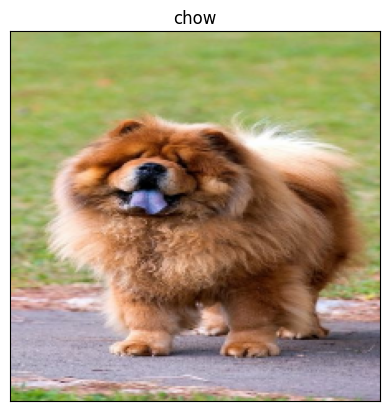

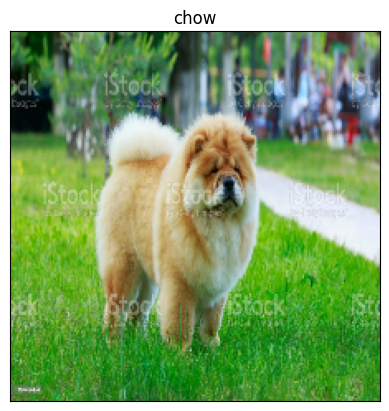

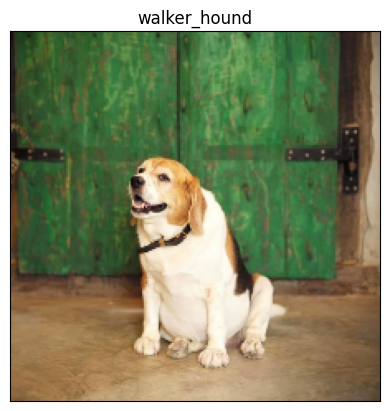

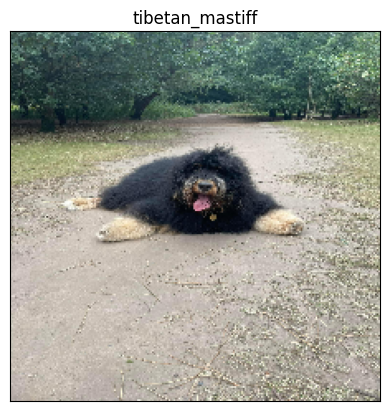

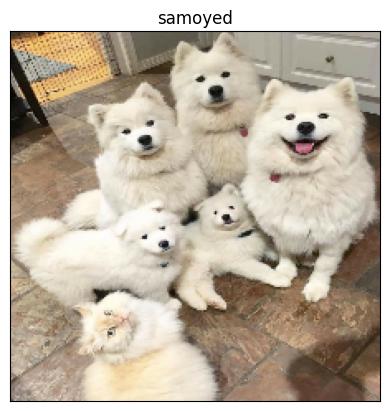

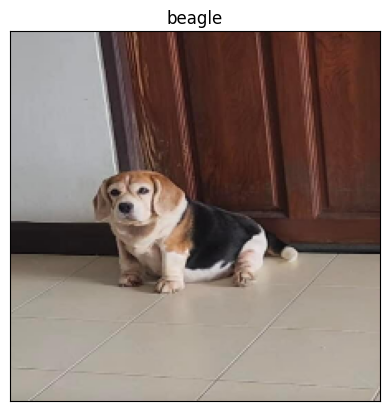

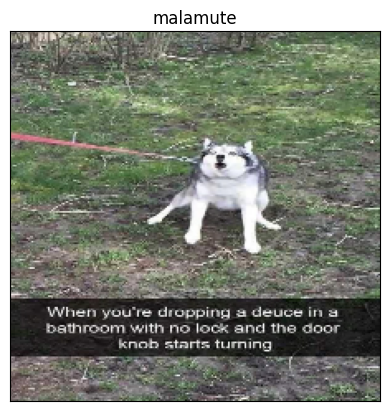

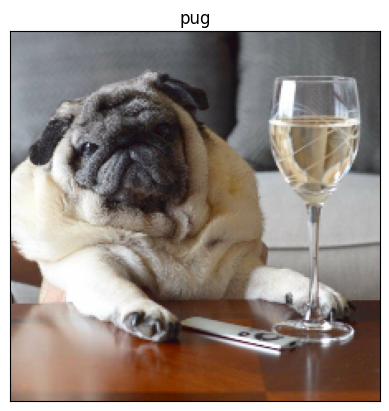

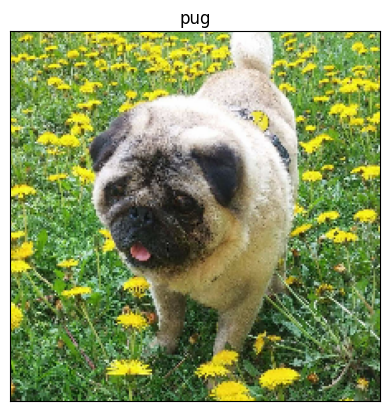

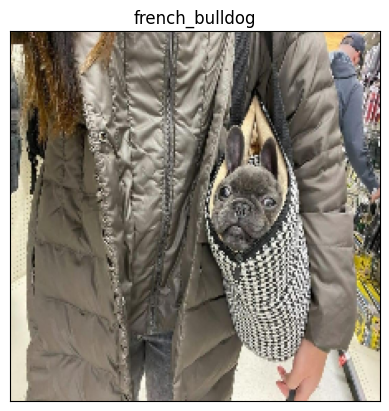

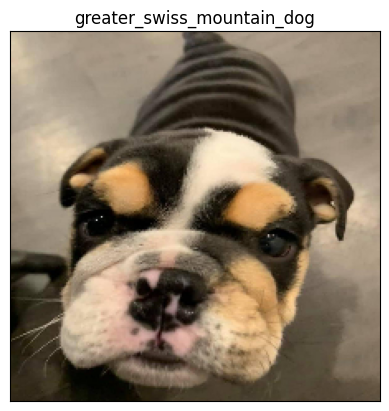

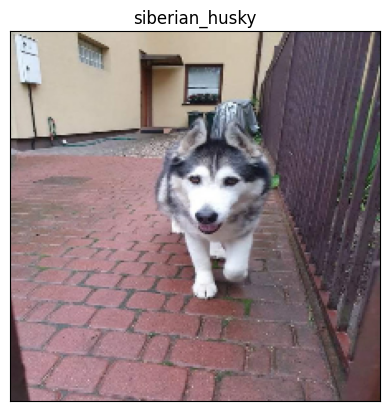

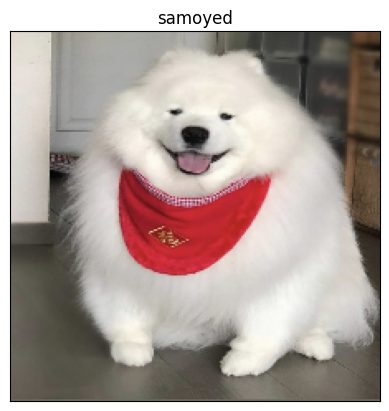

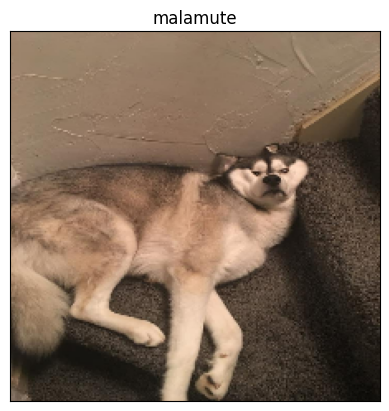

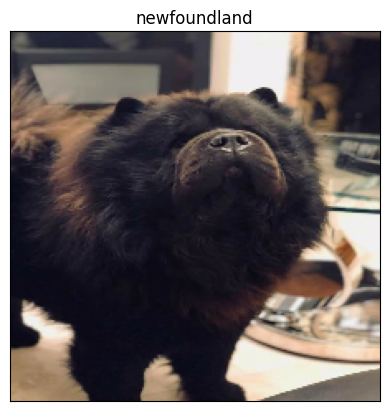

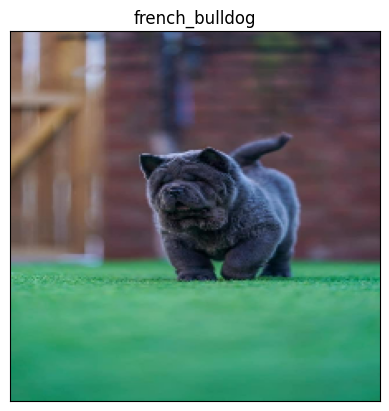

In [87]:
prediction_on_the_go("./images")